In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
s_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/train_set/signal_train.root")
b_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/train_set/bkg_train.root")

s_tree = s_file['tree']
b_tree = b_file['tree']


branch_names = ['lep_pt_0','lep_pt_1','lep_pt_2','lep_pt_3','deltaR_l0_l1','deltaR_l0_l2','deltaR_l0_l3',
 'deltaR_l1_l2','deltaR_l1_l3','deltaR_l2_l3' ,'invariant_mass_4lep'
]

s_arrays = s_tree.arrays(branch_names, library="pd")
b_arrays = b_tree.arrays(branch_names, library="pd")


df_s = pd.DataFrame(s_arrays)
df_b = pd.DataFrame(b_arrays)


In [3]:
#b_tree.keys()

In [4]:
df_s['Class'] = 1
df_b['Class'] = 0

print("Total Signal events: ",len(df_s))
print("Total Bkg events: ",len(df_b))

Total Signal events:  185020
Total Bkg events:  342174


In [5]:
df = pd.concat([df_s, df_b]).reset_index(drop=True).sample(frac=1)
y_df = df.pop('Class')

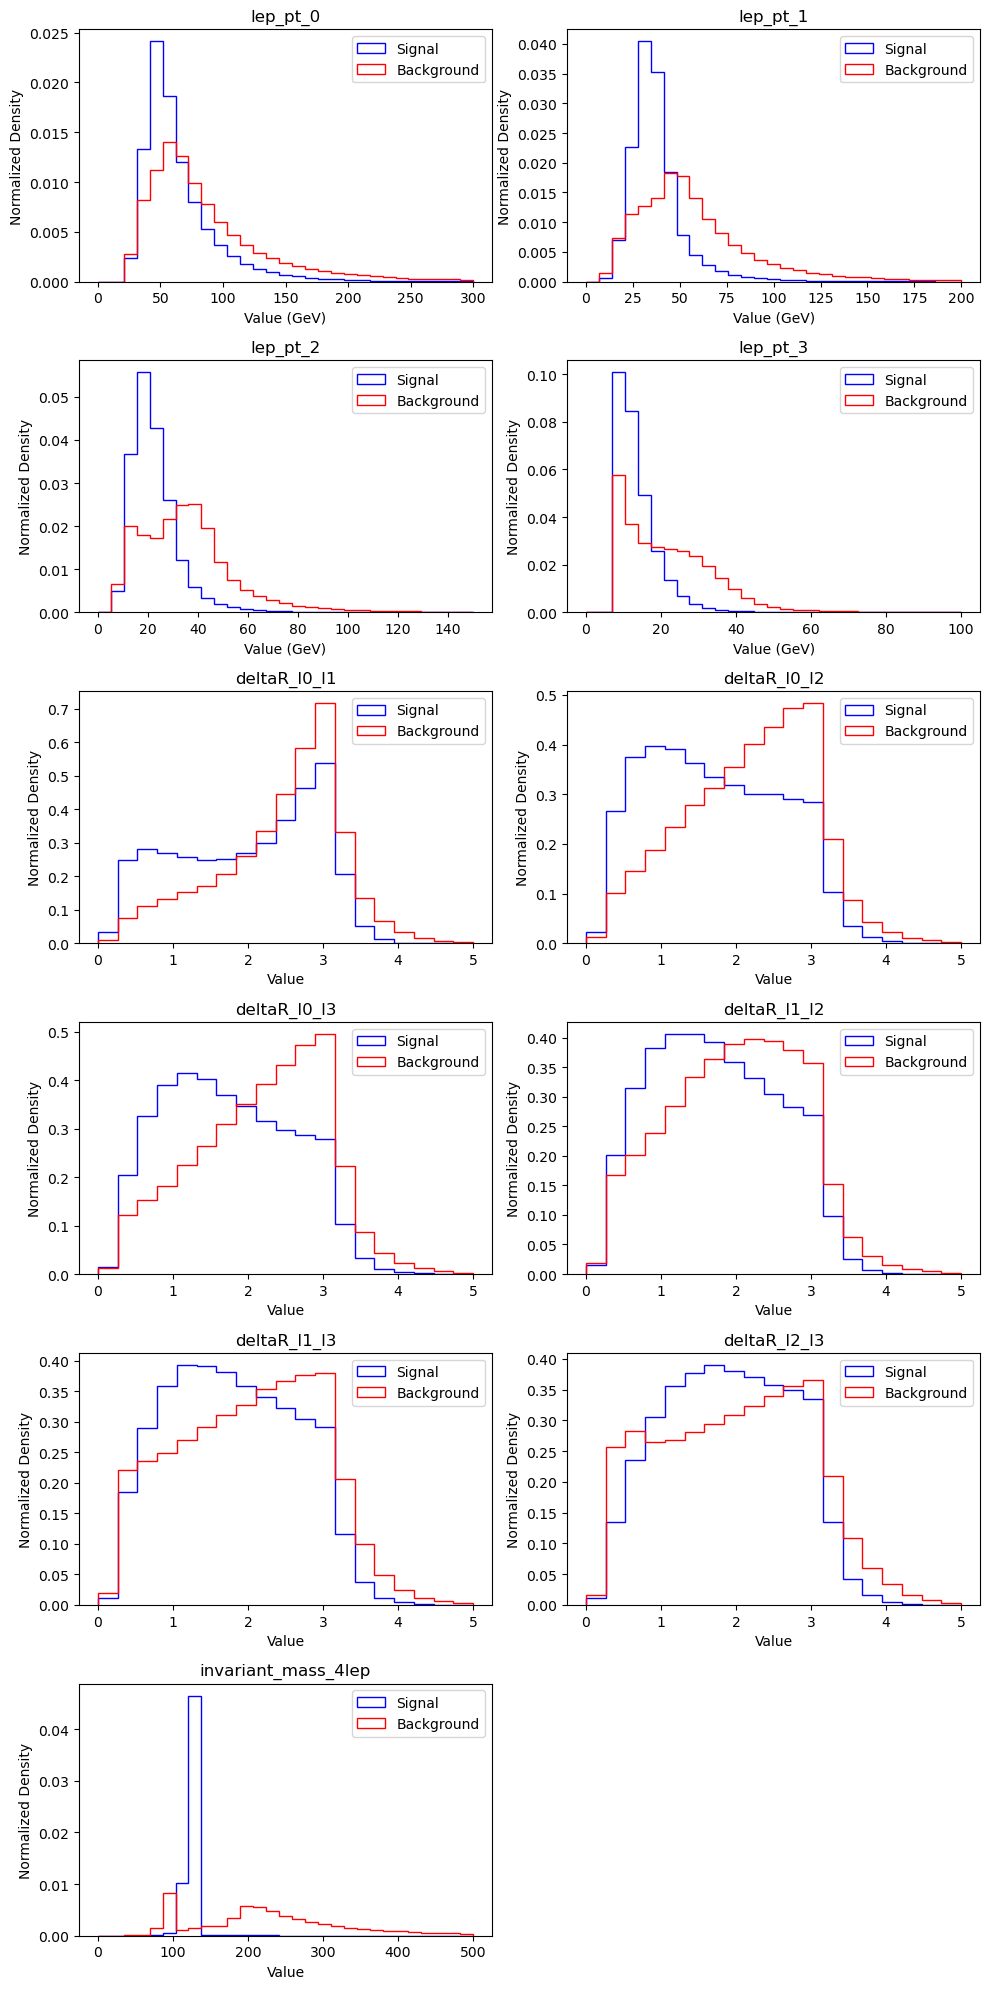

In [6]:
# Define features and bin ranges
features = [
    'lep_pt_0', 'lep_pt_1', 'lep_pt_2', 'lep_pt_3',
     'deltaR_l0_l1', 'deltaR_l0_l2',
    'deltaR_l0_l3', 'deltaR_l1_l2', 'deltaR_l1_l3', 'deltaR_l2_l3' ,'invariant_mass_4lep'
]

# Specify bin ranges for each feature
bin_ranges = {
    'lep_pt_0': (0, 300, 30),
    'lep_pt_1': (0, 200, 30),
    'lep_pt_2': (0, 150, 30),
    'lep_pt_3': (0, 100, 30),
    'deltaR_l0_l1': (0, 5, 20),
    'deltaR_l0_l2': (0, 5, 20),
    'deltaR_l0_l3': (0, 5, 20),
    'deltaR_l1_l2': (0, 5, 20),
    'deltaR_l1_l3': (0, 5, 20),
    'deltaR_l2_l3': (0, 5, 20),
    'invariant_mass_4lep': (0, 500, 30),


}

# Plotting normalized distributions of features for signal and background
plt.figure(figsize=(10, 20))

# Create subplots for each feature
for i, feature in enumerate(features):
    plt.subplot(6, 2, i + 1)  
    bin_range = bin_ranges[feature]
    bins = np.linspace(bin_range[0], bin_range[1], bin_range[2])
    
    # Check if the feature is one of the lepton pt features
    if 'lep_pt' in feature or feature == 'invariant_mass_4lep':
        # Convert from MeV to GeV
        signal_data = df_s[feature] / 1000  # Convert Signal pt to GeV
        background_data = df_b[feature] / 1000  # Convert Background pt to GeV
    else:
        signal_data = df_s[feature]
        background_data = df_b[feature]

    # Plot the histograms as step type
    plt.hist(signal_data, bins=bins, alpha=1.0, label='Signal', density=True, color='blue', histtype='step')
    plt.hist(background_data, bins=bins, alpha=1.0, label='Background', density=True, color='red', histtype='step')
    
    # Title and labels
    plt.title(feature)
    plt.xlabel('Value (GeV)' if 'lep_pt' in feature else 'Value')
    plt.ylabel('Normalized Density')
    plt.legend()

# Improve layout
plt.tight_layout()
plt.show()


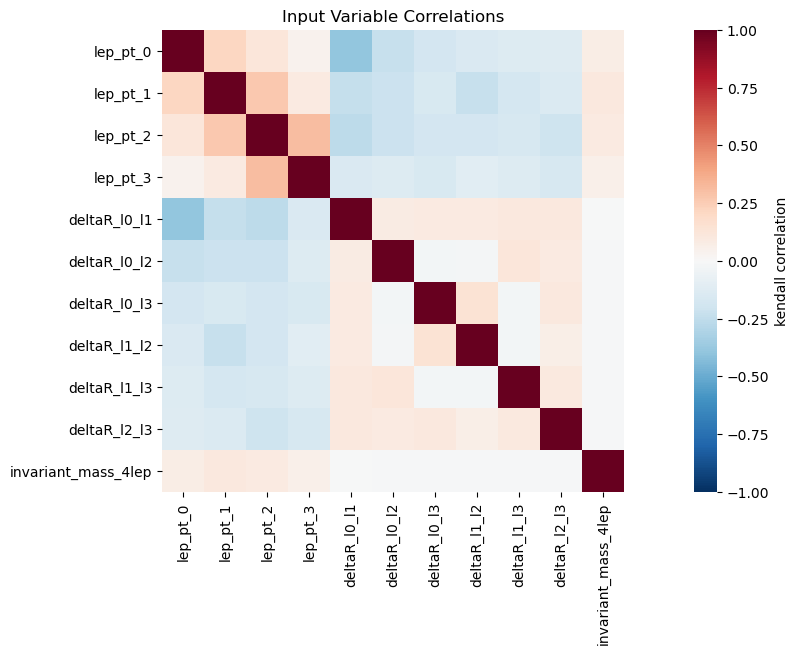

In [7]:
method = 'kendall'
correlations = df_s[branch_names].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (18,6))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import joblib

from tensorflow import keras
from tensorflow.keras import layers

X_train_1,X_test_1,y_train,y_test = train_test_split(df[branch_names],y_df,test_size=0.2,random_state=0)

In [10]:
# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

In [11]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.7699125221797896, 1: 1.4262260156773099}


In [12]:
#Define the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

#Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Precision'])

#Train the model
history = model.fit(
    X_train_np, y_train_np, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.2, class_weight=class_weight_dict
)


/lustre/work/client/users/santoshp/.conda/envs/sklearn/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
10544/10544 ━━━━━━━━━━━━━━━━━━━━ 10s 767us/step - Precision: 0.8412 - accuracy: 0.9221 - loss: 0.2004 - val_Precision: 0.9417 - val_accuracy: 0.9712 - val_loss: 0.0983
Epoch 2/20
10544/10544 ━━━━━━━━━━━━━━━━━━━━ 9s 758us/step - Precision: 0.9426 - accuracy: 0.9715 - loss: 0.0992 - val_Precision: 0.9440 - val_accuracy: 0.9723 - val_loss: 0.0959
Epoch 3/20
10544/10544 ━━━━━━━━━━━━━━━━━━━━ 10s 760us/step - Precision: 0.9480 - accuracy: 0.9731 - loss: 0.0953 - val_Precision: 0.9486 - val_accuracy: 0.9742 - val_loss: 0.0933
Epoch 4/20
10544/10544 ━━━━━━━━━━━━━━━━━━━━ 10s 756us/step - Precision: 0.9495 - accuracy: 0.9739 - loss: 0.0919 - val_Precision: 0.9599 - val_accuracy: 0.9752 - val_loss: 0.0890
Epoch 5/20
10544/10544 ━━━━━━━━━━━━━━━━━━━━ 10s 752us/step - Precision: 0.9510 - accuracy: 0.9741 - loss: 0.0909 - val_Precision: 0.9548 - val_accuracy: 0.9754 - val_loss: 0.0877
Epoch 6/20
10544/10544 ━━━━━━━━━━━━━━━━━━━━ 10s 757us/step - Precision: 0.9524 - accuracy: 0.9749 - loss: 

In [13]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate accuracy and precision
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)

print("Accuracy: ", accuracy)
print("Precision: ", precision)

3295/3295 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step
Accuracy:  0.9749144054856362
Precision:  0.952801972924756


3295/3295 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step


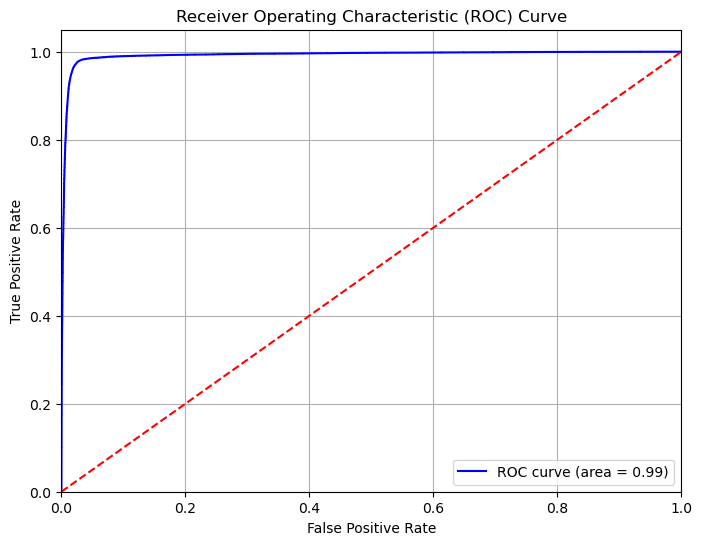

In [14]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).ravel()  # Flatten the array

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

4621/4621 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step
8560/8560 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
2134/2134 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step


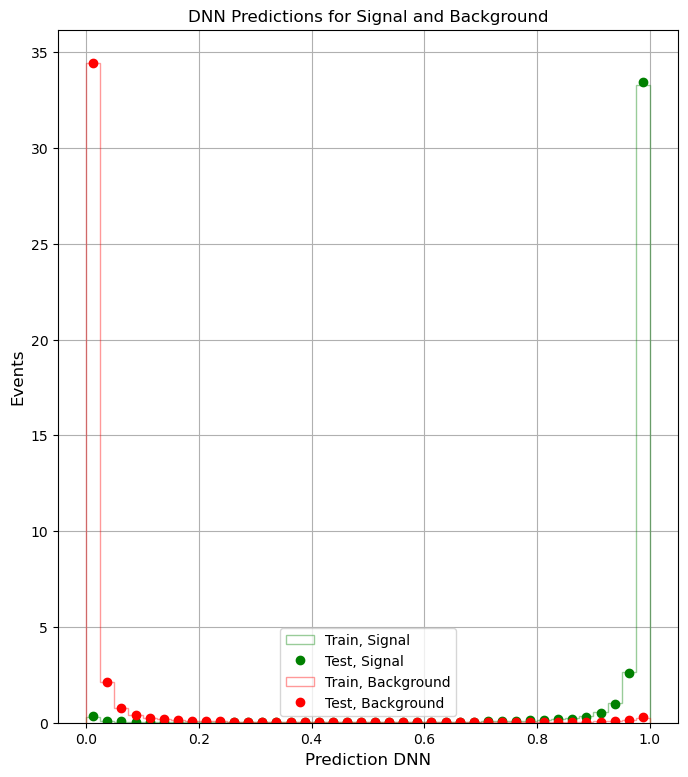

In [15]:
y_pred_signal_train = model.predict(X_train[y_train == 1])  # Predictions for training set, Signal
y_pred_signal_test = model.predict(X_test[y_test == 1])     # Predictions for test set, Signal
y_pred_background_train = model.predict(X_train[y_train == 0])  # Predictions for training set, Background
y_pred_background_test = model.predict(X_test[y_test == 0])     # Predictions for test set, Background


n_bins = 40
hist_range = (0, 1.0)
plt.figure(figsize=(8, 9))


plt.hist(y_pred_signal_train, bins=n_bins, range=hist_range, histtype='step', color="green", density=True, alpha=0.4, label="Train, Signal")
counts, bin_edges = np.histogram(y_pred_signal_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="green", label="Test, Signal")

plt.hist(y_pred_background_train, bins=n_bins, range=hist_range, histtype='step', density=True, alpha=0.4, color="red", label="Train, Background")
counts, bin_edges = np.histogram(y_pred_background_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="red", label="Test, Background")


plt.xlabel("Prediction DNN", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend()
plt.grid()
plt.title("DNN Predictions for Signal and Background")
plt.show()


In [16]:
##########Validate###############

In [17]:
########Evaluation Part#################### 

In [18]:
val_s_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/val_set/signal_val.root")
val_b_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/val_set/bkg_val.root")
val_d_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/val_set/data.root")

v_s_tree = val_s_file['tree']
v_b_tree = val_b_file['tree']
v_d_tree = val_d_file['tree']

branch_names = ['lep_pt_0','lep_pt_1','lep_pt_2','lep_pt_3','deltaR_l0_l1','deltaR_l0_l2','deltaR_l0_l3',
 'deltaR_l1_l2','deltaR_l1_l3','deltaR_l2_l3' ,'invariant_mass_4lep'
]
total_branch = branch_names + ['totalWeight', 'lep_eta_0', 'lep_eta_1', 'lep_eta_2', 'lep_eta_3', 
                               'lep_phi_0', 'lep_phi_1', 'lep_phi_2', 'lep_phi_3', 'lep_E_0', 
                               'lep_E_1', 'lep_E_2', 'lep_E_3', 'lep_n','jet_n' #,'invariant_mass_4lep'
                              ]

v_s_arrays = v_s_tree.arrays(branch_names, library="pd")
v_s_arrays_t = v_s_tree.arrays(total_branch, library="pd")

v_b_arrays = v_b_tree.arrays(branch_names, library="pd")
v_b_arrays_t = v_b_tree.arrays(total_branch, library="pd")

v_d_arrays = v_d_tree.arrays(branch_names, library="pd")
v_d_arrays_t = v_d_tree.arrays(total_branch, library="pd")


v_df_s = pd.DataFrame(v_s_arrays)
v_df_s_t = pd.DataFrame(v_s_arrays_t)

v_df_b = pd.DataFrame(v_b_arrays)
v_df_b_t = pd.DataFrame(v_b_arrays_t)

v_df_d = pd.DataFrame(v_d_arrays)
v_df_d_t = pd.DataFrame(v_d_arrays_t)

In [19]:
print("Total Signal events: ",len(v_df_s))
print("Total Bkg events: ",len(v_df_b))
print("Total Data events: ",len(v_df_d))

Total Signal events:  370040
Total Bkg events:  684349
Total Data events:  507


In [20]:
y_s_1 = scaler.transform(v_df_s)
y_b_1 = scaler.transform(v_df_b)
y_d_1 = scaler.transform(v_df_d)

y_s = model.predict(y_s_1)
y_b = model.predict(y_b_1)
y_d = model.predict(y_d_1)

11564/11564 ━━━━━━━━━━━━━━━━━━━━ 6s 475us/step
21386/21386 ━━━━━━━━━━━━━━━━━━━━ 10s 479us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


In [22]:
v_df_s_t['bdt_score'] = y_s
v_df_b_t['bdt_score'] = y_b
v_df_d_t['bdt_score'] = y_d

In [23]:
################stack plot#########

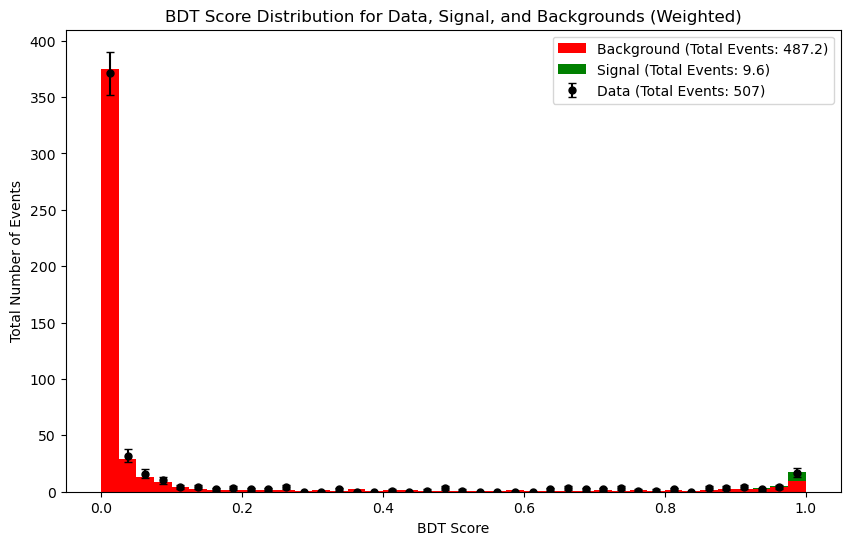

In [24]:
data_to_plot = [v_df_b_t['bdt_score'], v_df_s_t['bdt_score']]
weights_to_use = [v_df_b_t['totalWeight'], v_df_s_t['totalWeight']]

# Calculate event totals
total_signal = np.sum(v_df_s_t['totalWeight'])
total_background = np.sum(v_df_b_t['totalWeight'])
total_data = len(v_df_d_t)

# Stacked histogram for signal and background
plt.figure(figsize=(10, 6))
plt.hist(data_to_plot, bins=40, range=(0, 1), weights=weights_to_use, stacked=True, 
         label=[f'Background (Total Events: {total_background:.1f})', 
                f'Signal (Total Events: {total_signal:.1f})'],
         color=['red', 'green'])

# Calculate bin centers for data
bins = np.linspace(0, 1, 41)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Data histogram and errors
data_hist, _ = np.histogram(v_df_d_t['bdt_score'], bins=bins)
data_errors = np.sqrt(data_hist)


plt.errorbar(bin_centers, data_hist, fmt='o', yerr=data_errors,
             label=f'Data (Total Events: {total_data})', color='black', 
             markersize=5, capsize=3)

plt.title('BDT Score Distribution for Data, Signal, and Backgrounds (Weighted)')
plt.xlabel('BDT Score')
plt.ylabel('Total Number of Events')
# plt.yscale('log') 

plt.legend()
plt.show()

In [25]:
#Calculate Signigicance

In [35]:
# Define bins as before
bins = np.linspace(0, 1, 41)  # 20 bins from 0 to 1 (or adjust as needed)

# Calculate histograms for signal and background individually
signal_hist, _ = np.histogram(v_df_s_t['bdt_score'], bins=bins, weights=v_df_s_t['totalWeight'])
background_hist, _ = np.histogram(v_df_b_t['bdt_score'], bins=bins, weights=v_df_b_t['totalWeight'])

# Calculate the histogram for data as well
data_hist, _ = np.histogram(v_df_d_t['bdt_score'], bins=bins)

# Sum the counts in the last two bins for each histogram
# The last two bins are at indices -2 and -1
signal_last_two = signal_hist[-2:].sum()
background_last_two = background_hist[-1:].sum()
data_last_two = data_hist[-2:].sum()

# Print the values
print(f"Last two bins:\nSignal: {signal_last_two:.3f}\nBackground: {background_last_two:.3f}\nData: {data_last_two:.3f}")


Last two bins:
Signal: 8.510
Background: 9.704
Data: 21.000


In [36]:
# Calculate the significance in the last two bins
N_sig_last_two = signal_last_two
N_bg_last_two = background_last_two

# Apply the signal significance formula (adjust uncertainty model as needed)
signal_significance_last_two = N_sig_last_two / np.sqrt(N_bg_last_two + 0.3 * N_bg_last_two**2)
print(f"Signal Significance in Last Two Bins: {signal_significance_last_two:.3f}")


Signal Significance in Last Two Bins: 1.381


In [37]:
# Define observed signal as the excess of data over background
N_sig_observed_last_two = max(data_last_two - background_last_two, 0)  # Clip to avoid negative signal
N_bg_last_two = background_last_two  # Background remains the same

# Calculate observed significance
observed_significance_last_two = N_sig_observed_last_two / np.sqrt(N_bg_last_two + 0.3 * N_bg_last_two**2)

print(f"Observed Significance in Last Two Bins: {observed_significance_last_two:.3f}")


Observed Significance in Last Two Bins: 1.834
